In [0]:
from gensim.models.keyedvectors import KeyedVectors
#import gensim
#import pandas as pn
from nltk import word_tokenize
import numpy as np
import torch
print(torch.__version__)
#import torchvision.transforms as transforms
#from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
#from torchvision import datasets
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
!pip install skorch
import skorch
from skorch import NeuralNetClassifier,NeuralNet
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score
from mpl_toolkits import mplot3d
import scipy.interpolate as interp
from mpl_toolkits.mplot3d import Axes3D

1.3.1
     |████████████████████████████████| 112kB 5.0MB/s 


In [0]:
from google.colab import drive 
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
print("----------CARGANDO VECTORES DE EMBEDDING--------------")
#wordvectors_file_vec = path_vectors
path_vectors = 'drive/My Drive/glove-sbwc.i25.vec'
wordvectors = KeyedVectors.load_word2vec_format(path_vectors)
print("----------FINISHED CARGANDO VECTORES DE EMBEDDING--------------\n")

----------CARGANDO VECTORES DE EMBEDDING--------------


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


----------FINISHED CARGANDO VECTORES DE EMBEDDING--------------



In [0]:
#cargar csv con preguntas preprocesadas
print("-----------CARGANDO/CREANDO PREGUNTAS PREPROCESADAS--------------")
#correctedData = preprocesamiento.preprocesar(dataset.values,1) #Dataset lematizado, descomentar en caso de crear otro dataset 
path_dataset = "preprocessedQuestions_lem_completadas.csv"
correctedData = pd.read_csv(path_dataset,delimiter=',',header=None) #comentar esta linea en caso de descomentar la anterior
print("----------FINISHED CARGANDO/CREANDO PREGUNTAS PREPROCESADAS-------------\n")

-----------CARGANDO/CREANDO PREGUNTAS PREPROCESADAS--------------
----------FINISHED CARGANDO/CREANDO PREGUNTAS PREPROCESADAS-------------



In [0]:
#obtener datos utiles sobre el dataset
labels = correctedData.values[:,0]
print("Shape de corrected data: ",correctedData.shape)
cantidad_labels = correctedData.values[len(correctedData.values)-1,0] + 1
cantidad_preg = correctedData.shape[0]
print("Cantidad de clases: ",cantidad_labels)
print("Cantidad de patrones: ",cantidad_preg)
print("Lista de clases para cada pregunta :",labels)
correctedData = correctedData.values

Shape de corrected data:  (1527, 2)
Cantidad de clases:  106
Cantidad de patrones:  1527
Lista de clases para cada pregunta : [0 0 0 ... 105 105 105]


In [0]:
def create_tensor_prom_and_embedding(Xtext,cant_patrones,wordvectors):
    token_idx = 0
    wordSet = {} #diccionario de tokens. clave -> token valor -> indice de la posicion en el tensor de embeddings
    embeddingMat = [] #array (que luego sera convertido a tensor) de embeddings vocabulario propio
    promMat = np.zeros((300,cant_patrones),dtype=np.float32) #array de promedios de vectores de embeddings vocabulario original -> decision: no promediar embeddings no conocidos
    for i in range(cant_patrones):
        words = word_tokenize(Xtext[i,0])
        words_in_sentence = [] #lista de indices de las palabras que se encuentran en la oracion actual
        prom = np.zeros((300)) #acumulador de vectores de embeddings de las palabras de la oracion actual
        for w in words: #w is a token
            if w not in wordSet: #la palabra no se encuentra en el diccionario generado: se debe agregar
                wordSet[w] = token_idx
                if w in wordvectors:
                    words_in_sentence.append(token_idx)
                    s = wordvectors.get_vector(w)
                    embeddingMat.append(s) #Acá hay que meter al tensor en verdad. -> precision en los decimales
                    token_idx += 1
                else: #la palabra no esta en el vocabulario original, agregamos un vector de numeros aleatorios que luego sera entrenado
                    embeddingMat.append(np.random.normal(0,0.2,300))
                    token_idx+=1
            else: #la palabra ya se encuentra en el diccionario generado: debemos asignarle a la lista de indices el indice del token corresp
                words_in_sentence.append(wordSet[w])
        for indx in words_in_sentence: #promediamos solo los vectores de embedding encontrados en el vocabulario original
            prom += embeddingMat[indx] #Calcular promedio con embeddingMat y los indices de words_in_sentence
        cant_palabras = len(words_in_sentence)
        if len(words_in_sentence)>0:
            promMat[:,i] = prom/cant_palabras

    tensorEmbedding = torch.Tensor(embeddingMat)
    promMat = np.transpose(promMat)
    X = torch.from_numpy(promMat)
    X = X.float()
    return X,tensorEmbedding,wordSet

In [0]:
import nltk
nltk.download('punkt')
X_text = np.zeros((cantidad_preg,1), dtype=object)
Y = np.zeros((cantidad_preg),dtype=np.int64)
for i in range(cantidad_preg):
    X_text[i] = correctedData[i,1]
    Y[i] = correctedData[i,0]

Y = torch.from_numpy(Y)
print(Y)
X,_,_ = create_tensor_prom_and_embedding(X_text,cantidad_preg,wordvectors)
print(X.shape)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
tensor([  0,   0,   0,  ..., 105, 105, 105])
torch.Size([1527, 300])


In [0]:
parameters = {    
'hidden_layer_sizes' : [(200),(100),(250,200,100),(150),(250,150),(250),(250,150,120)],
'max_iter' : [60,90,120,150,200,250],
'alpha' : [0.00001,0.0001,0.001,0.1],
'batch_size' : [750,300,1000,1500]
}

net = MLPClassifier(hidden_layer_sizes=(100))
candidatos = 20
gs = RandomizedSearchCV(net,parameters,verbose=2,n_jobs=-1,cv=10,scoring='balanced_accuracy',n_iter=candidatos)

X_numpy = X.numpy()
Y_numpy = Y.numpy()
X_train,X_test,y_train,y_test = train_test_split(X_numpy,Y_numpy,shuffle=True,stratify=Y_numpy,test_size=0.1,random_state=12)

gs.fit(X_train,y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 12.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=100,
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_iter=200, momentum=0.9,
                                           n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           random...
                                           verbose=False, warm_start=False),
                   iid='warn', n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': [

In [0]:
hidden_layer_sizes = []
max_epochs = []
alpha= []
batch_size=[]
std=[]
score=[]
y_test_tensor = torch.LongTensor(y_test)
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                results['mean_test_score'][candidate],
                results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            score.append(results['mean_test_score'][candidate])
            std.append(results['std_test_score'][candidate])
            hidden_layer_sizes.append(results['params'][candidate]['hidden_layer_sizes'])
            batch_size.append(results['params'][candidate]['batch_size'])
            alpha.append(results['params'][candidate]['alpha'])
            max_epochs.append(results['params'][candidate]['max_iter'])

report(gs.cv_results_,candidatos)   

Model with rank: 1
Mean validation score: 0.730 (std: 0.035)
Parameters: {'max_iter': 250, 'hidden_layer_sizes': 250, 'batch_size': 750, 'alpha': 0.0001}

Model with rank: 2
Mean validation score: 0.724 (std: 0.038)
Parameters: {'max_iter': 200, 'hidden_layer_sizes': 200, 'batch_size': 1000, 'alpha': 0.0001}

Model with rank: 3
Mean validation score: 0.714 (std: 0.039)
Parameters: {'max_iter': 200, 'hidden_layer_sizes': 150, 'batch_size': 750, 'alpha': 0.1}

Model with rank: 4
Mean validation score: 0.711 (std: 0.038)
Parameters: {'max_iter': 250, 'hidden_layer_sizes': 100, 'batch_size': 750, 'alpha': 1e-05}

Model with rank: 5
Mean validation score: 0.697 (std: 0.033)
Parameters: {'max_iter': 200, 'hidden_layer_sizes': 100, 'batch_size': 750, 'alpha': 1e-05}

Model with rank: 6
Mean validation score: 0.695 (std: 0.037)
Parameters: {'max_iter': 90, 'hidden_layer_sizes': 250, 'batch_size': 750, 'alpha': 0.1}

Model with rank: 7
Mean validation score: 0.689 (std: 0.035)
Parameters: {'max

In [0]:
print("hidden_layer_sizes=",hidden_layer_sizes)
print("max_epochs=",max_epochs)
print("alpha=",alpha)
print("batch_size=",batch_size)
print("std=",std)
print("score=",score)

hidden_layer_sizes= [250, 200, 150, 100, 100, 250, (250, 200, 100), (250, 150), (250, 200, 100), (250, 200, 100), (250, 200, 100), (250, 200, 100), 100, (250, 150, 120), (250, 200, 100), (250, 200, 100), 200, 150, 150, 100]
max_epochs= [250, 200, 200, 250, 200, 90, 90, 90, 150, 250, 250, 90, 120, 200, 60, 60, 90, 60, 60, 90]
alpha= [0.0001, 0.0001, 0.1, 1e-05, 1e-05, 0.1, 1e-05, 1e-05, 0.001, 1e-05, 0.1, 0.001, 0.1, 0.1, 0.0001, 1e-05, 0.0001, 0.1, 0.1, 1e-05]
batch_size= [750, 1000, 750, 750, 750, 750, 300, 1000, 1500, 1500, 1500, 750, 750, 300, 300, 750, 1500, 750, 1000, 1500]
std= [0.03504257749365058, 0.037851710400503336, 0.038617808771831706, 0.03774875742818829, 0.03263096013491257, 0.03696277459513382, 0.03540371141174583, 0.03234962671238723, 0.03757566410149036, 0.05038644128798207, 0.04584784381346079, 0.034641867809446475, 0.0338341602092015, 0.0418172382851746, 0.03561919095147398, 0.03622462067747258, 0.031830658215865504, 0.03593793742629963, 0.020077622027466234, 0.0376

In [0]:
probs = gs.best_estimator_.predict_proba(X_test)
acc = balanced_accuracy_score(y_test_tensor,np.argmax(probs,axis=1))
print("tasa de acierto obtenida: ",acc)

tasa de acierto obtenida:  0.75


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Z contains NaN values. This may result in rendering artifacts.


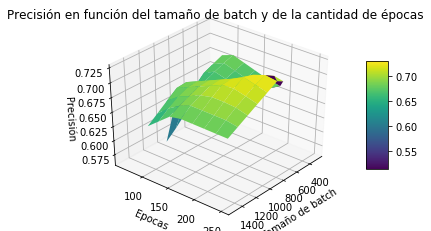

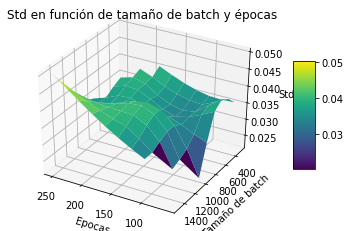

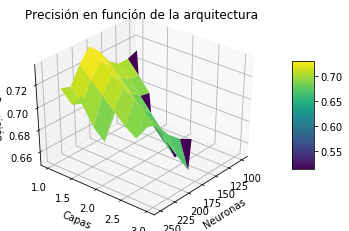

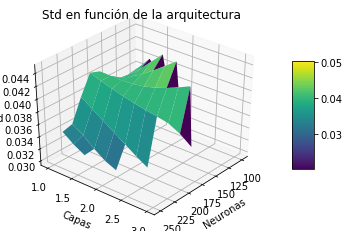

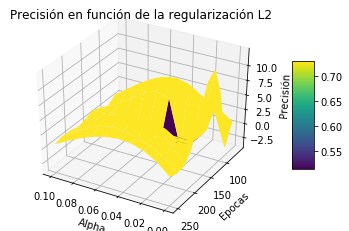

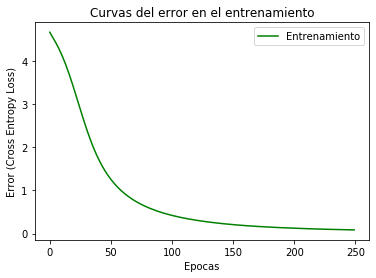

In [0]:
hidden_dim = hidden_layer_sizes
num_layers = list(map(lambda x: 1 if type(x)==int else len(x), hidden_dim))
hidden_dim = list(map(lambda x: x if type(x)==int else np.average(x), hidden_dim))

ejex = batch_size
ejey = max_epochs
#print(ejez)
#print(len(ejez))
#ejez = [0.5,0.3,0.4,0.33,0.6,0.45,0.75,0.8,0.2,0.47,0.56,0.66,0.9,0.87,0.67,0.43]
ejez = score
plotx,ploty, = np.meshgrid(np.linspace(np.min(ejex),np.max(ejex),10),\
                           np.linspace(np.min(ejey),np.max(ejey),10))
plotz = interp.griddata((ejex,ejey),ejez,(plotx,ploty),method='linear')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(35,40)
ax.set_xlabel('Tamaño de batch')
ax.set_ylabel('Epocas')
ax.set_zlabel('Precisión')
ax.set_title('Precisión en función del tamaño de batch y de la cantidad de épocas')

surf = ax.plot_surface(plotx,ploty,plotz,vmin=np.nanmin(ejez),vmax = np.nanmax(ejez),cstride=1,rstride=1,cmap='viridis')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("prueba2_Epocas_Batch_Precision.svg")

###########################################################################################################

ejex = max_epochs
ejey = batch_size
ejez = std

plotx,ploty, = np.meshgrid(np.linspace(np.min(ejex),np.max(ejex),10),\
                           np.linspace(np.min(ejey),np.max(ejey),10))
plotz = interp.griddata((ejex,ejey),ejez,(plotx,ploty),method='cubic')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(35,120)
ax.set_xlabel('Epocas')
ax.set_ylabel('Tamaño de batch')
ax.set_zlabel('Std')
ax.set_title('Std en función de tamaño de batch y épocas')

surf = ax.plot_surface(plotx,ploty,plotz,vmin=np.nanmin(ejez),vmax = np.nanmax(ejez),cstride=1,rstride=1,cmap='viridis')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("prueba2_Epocas_Batch_STD.svg")

##############################################################################################################

ejex = hidden_dim
ejey = num_layers
ejez = score

plotx,ploty, = np.meshgrid(np.linspace(np.min(ejex),np.max(ejex),10),\
                           np.linspace(np.min(ejey),np.max(ejey),10))
plotz = interp.griddata((ejex,ejey),ejez,(plotx,ploty),method='cubic')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(35,40)
ax.set_xlabel('Neuronas')
ax.set_ylabel('Capas')
ax.set_zlabel('Precisión')
ax.set_title('Precisión en función de la arquitectura')

surf = ax.plot_surface(plotx,ploty,plotz,vmin=np.nanmin(ejez),vmax = np.nanmax(ejez),cstride=1,rstride=1,cmap='viridis')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("prueba2_Neuronas_Capas_Precision.svg")

###########################################################################################

ejex = hidden_dim
ejey = num_layers
ejez = std

plotx,ploty, = np.meshgrid(np.linspace(np.min(ejex),np.max(ejex),10),\
                           np.linspace(np.min(ejey),np.max(ejey),10))
plotz = interp.griddata((ejex,ejey),ejez,(plotx,ploty),method='cubic')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(35,40)
ax.set_xlabel('Neuronas')
ax.set_ylabel('Capas')
ax.set_zlabel('Std')
ax.set_title('Std en función de la arquitectura')

surf = ax.plot_surface(plotx,ploty,plotz,vmin=np.nanmin(ejez),vmax = np.nanmax(ejez),cstride=1,rstride=1,cmap='viridis')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("prueba2_Neuronas_Capas_STD.svg")

################################################################################################################

ejex = alpha
ejey = max_epochs
ejez = score

plotx,ploty, = np.meshgrid(np.linspace(np.min(ejex),np.max(ejex),10),\
                           np.linspace(np.min(ejey),np.max(ejey),10))
plotz = interp.griddata((ejex,ejey),ejez,(plotx,ploty),method='cubic')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(35,120)
ax.set_xlabel('Alpha')
ax.set_ylabel('Epocas')
ax.set_zlabel('Precisión')
ax.set_title('Precisión en función de la regularización L2')

surf = ax.plot_surface(plotx,ploty,plotz,vmin=np.nanmin(ejez),vmax = np.nanmax(ejez),cstride=1,rstride=1,cmap='viridis')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("prueba2_Alpha_Epocas_Precision.svg")

################################################################################################################

epochs = [i for i in range(max_epochs[0])]
train_loss = gs.best_estimator_.loss_curve_
fig1 = plt.figure()
plt.plot(epochs,train_loss,'g-')
#plt.plot(epochs,valid_loss,'r-')
plt.title('Curvas del error en el entrenamiento')
plt.xlabel('Epocas')
plt.ylabel('Error (Cross Entropy Loss)')
plt.legend(['Entrenamiento'])
plt.savefig("prueba2_TrainVsVal.svg")

plt.show()